# Data Cleaning

Exclusion critera:
1. Don't use social media
2. Was aware of one of the rumours
3. Failed either attention check
2. An outlier in completion time (>3 std devs below the mean)


## Get data from Azure

In [1]:
from pymongo import MongoClient
from secret import URI
import json
STUDY_ID ="60b37265a9f60881975de69e"
client = MongoClient(URI)
db = client["thesis-db"]

**write copies to file**

In [2]:
for collection in db.list_collection_names():
    items = list(db[collection].find({"STUDY_ID": STUDY_ID}))
    fp = f"../data/raw/{STUDY_ID}-{collection}.json"
    with open(fp, 'w') as outfile:
        json.dump(items, outfile, sort_keys=True, indent=4)

In [3]:
import pandas as pd
import numpy as np
participants = pd.DataFrame.from_records(list(db["participants"].find({"STUDY_ID": STUDY_ID})))
num_participants = len(participants["PROLIFIC_PID"].unique())
dummies = ["gender","affiliatedMovements","socialMedias"]
for col in dummies:
    participants = participants.explode(col)
participants = pd.get_dummies(participants,columns=dummies).max(level=0)
# assert len(participants) == num_participants, "Number of participants changed"
og_num_participants = len(participants["PROLIFIC_PID"].unique())
num_participants = og_num_participants
print(f"Original number of participants: {num_participants}")

Original number of participants: 189


In [4]:
to_drop = pd.Series(None,name="PROLIFIC_PID",dtype=str)

### 1. Drop participants who don't use social media

In [5]:
sm_cols = [c for c in participants.columns if "socialMedias" in c and not "none" in c]
# TO TEST: Uncomment the "none" category to see if there is anyone who ticked it
no_sm = (participants[sm_cols] == 0).T.all()
if "socialMedias_None" in participants.columns:
    no_sm = no_sm | participants["socialMedias_None"].astype(bool)
no_sm = pd.Series(participants[no_sm]["PROLIFIC_PID"].unique())
to_drop = pd.Series(to_drop.append(no_sm))
num_no_sm = len(no_sm)
num_participants -= num_no_sm
print(f"{num_no_sm} don't have social media, {num_participants} remaining participants.")

2 don't have social media, 187 remaining participants.


### 2. Drop participants who were aware of either rumour

In [6]:
mappings = {
    "pass": True,
    "fail": False,
    "true": True,
    "false": False
}

In [7]:
r1_check = pd.DataFrame.from_records(list(db["rumour-one-check"].find({"STUDY_ID": STUDY_ID})))
r2_check = pd.DataFrame.from_records(list(db["rumour-two-check"].find({"STUDY_ID": STUDY_ID})))
rumour_check = r1_check.merge(r2_check,
                              left_on="PROLIFIC_PID",
                              right_on="PROLIFIC_PID",
                              suffixes=("R1","R2"),
                              how="inner")

for col in list(["awareR1","awareR2","attentionCheckR1","attentionCheckR2"]):
      rumour_check[col] = rumour_check[col].map(mappings)
# assert len(rumour_check) == len(participants), f"rumour check (n={len(rumour_check)}) has different row length from participants (n={len(participants)})"

In [8]:
aware = rumour_check["awareR1"].astype(bool) | rumour_check["awareR2"].astype(bool)
aware = pd.Series(rumour_check[aware]["PROLIFIC_PID"].unique())
to_drop = pd.Series(to_drop.append(aware))
num_aware = len(aware)
num_participants -= num_aware
print(f"{num_aware} aware of a rumour, {num_participants} remaining participants.")

61 aware of a rumour, 126 remaining participants.


### 3. Drop participants who failed either attention check

In [9]:
no_attention = ~(rumour_check["attentionCheckR1"].astype(bool) & rumour_check["attentionCheckR2"].astype(bool))
no_attention = pd.Series(rumour_check[no_attention]["PROLIFIC_PID"].unique())
to_drop = pd.Series(to_drop.append(no_attention))
num_no_attention = len(no_attention)
num_participants -= num_no_attention
print(f"{num_no_attention} failed attention check, {num_participants} remaining participants.")

3 failed attention check, 123 remaining participants.


### 5. Drop participants who were outliers in the amount of time taken

Outlier: participants who the amount of time taken is more than 3 standard deviations below the mean 
- not above as we put a time cap on the time taken

In [10]:
r1_posts = pd.DataFrame.from_records(list(db["rumour-one-results"].find({"STUDY_ID": STUDY_ID})))
r1_posts = r1_posts.explode("posts")
r1_posts = pd.concat([r1_posts.drop(['posts'], axis=1), r1_posts['posts'].apply(pd.Series)], axis=1)

r2_posts = pd.DataFrame.from_records(list(db["rumour-two-results"].find({"STUDY_ID": STUDY_ID})))
r2_posts = r2_posts.explode("posts")
r2_posts = pd.concat([r2_posts.drop(['posts'], axis=1), r2_posts['posts'].apply(pd.Series)], axis=1)
posts = pd.concat([r1_posts,r2_posts])

<AxesSubplot:ylabel='Frequency'>

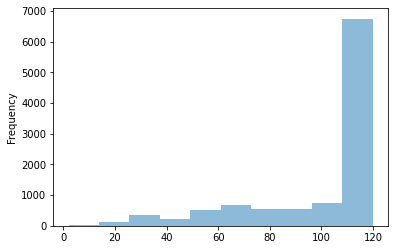

In [11]:
from scipy.stats import zscore
posts.secondsTaken.plot.hist(alpha=0.5)
z_scores = zscore(posts["secondsTaken"])
outliers = posts[z_scores < -3]
outliers.secondsTaken.plot.hist(alpha=0.5)

In [12]:
if len(outliers["PROLIFIC_PID"].unique()):
    thresh, mean = outliers["secondsTaken"].max(), posts["secondsTaken"].mean()
    drop = input(f"Drop every participant who took {thresh} seconds or fewer (mean={mean:.2f})? (YES/NO)")
    if drop.lower() == "yes":
        outliers = pd.Series(outliers["PROLIFIC_PID"].unique())
        num_outliers = len(outliers)
        to_drop = pd.Series(to_drop.append(outliers))
        num_participants -= num_outliers
        print(f"{num_outliers} outlier(s) in completion time, {num_participants} remaining participants.")
    else:
        print(f"Not dropping. {num_participants} remaining participants.")
else:
    print("No outliers")

Drop every participant who took 18 seconds or fewer (mean=102.22)? (YES/NO) YES


2 outlier(s) in completion time, 121 remaining participants.


> Instead, we analyze our data at the level of the posts (a boolean variable indicating whether the participant shared that specific post; 56 observations per partcipant using a single binomial logistic regression with a random effect on the participant ID and post ID standard errors clustered on both participant and headline and including experimental session dummies. Our regression takes the control condition as the baseline and tests for a warning effect (or, potentially, a bacfire effect if the warning hurts rather than helps) with a Warned dummy that indicates a headline being in the warning treatment and having a warning, and tests for an implied truth effect with an Untagged dummy that indicates a headline being in the warning treatment and not having a warning

In [13]:
posts["misleading"] = ((posts["code"] == "affirms") & (posts["evidence"] == "low")) | ((posts["code"] == "denies") & (posts["evidence"] == "high"))
posts["untagged"] = (posts["condition"] == "treatment") & posts["misleading"] & (~posts["warning"])
posts.head()

,_id,PROLIFIC_PID,SESSION_ID,STUDY_ID,condition,timeSubmitted,secondsTaken,id,rumour,code,evidence,warning,reshared,clickedWarning,timestamp,posterGender,posterId,misleading,untagged
0,5dd365ac670d1a36abffcea1,5dd365ac670d1a36abffcea1,60b8a3e5d3c4976eb8c2cba9,60b37265a9f60881975de69e,treatment,2021-06-03T09:50:15.953Z,120,1.283849e+18,R1,neutral,high,False,False,False,3,male,RnJlZGVyaWNrIFdvb2RodHRwczovL3JhbmRvbXVzZXIubW...,False,False
0,5dd365ac670d1a36abffcea1,5dd365ac670d1a36abffcea1,60b8a3e5d3c4976eb8c2cba9,60b37265a9f60881975de69e,treatment,2021-06-03T09:50:15.953Z,120,1.283767e+18,R1,neutral,high,False,False,False,4,female,S2F0aWUgTXVycGh5aHR0cHM6Ly9yYW5kb211c2VyLm1lL2...,False,False
0,5dd365ac670d1a36abffcea1,5dd365ac670d1a36abffcea1,60b8a3e5d3c4976eb8c2cba9,60b37265a9f60881975de69e,treatment,2021-06-03T09:50:15.953Z,120,1.283508e+18,R1,denies,high,True,False,False,11,male,R2FyeSBIb3BraW5zaHR0cHM6Ly9yYW5kb211c2VyLm1lL2...,True,False
0,5dd365ac670d1a36abffcea1,5dd365ac670d1a36abffcea1,60b8a3e5d3c4976eb8c2cba9,60b37265a9f60881975de69e,treatment,2021-06-03T09:50:15.953Z,120,1.283371e+18,R1,affirms,high,False,False,False,11,female,V2lsbGllIENsYXJraHR0cHM6Ly9yYW5kb211c2VyLm1lL2...,False,False
0,5dd365ac670d1a36abffcea1,5dd365ac670d1a36abffcea1,60b8a3e5d3c4976eb8c2cba9,60b37265a9f60881975de69e,treatment,2021-06-03T09:50:15.953Z,120,1.283538e+18,R1,affirms,high,False,True,False,13,female,TWVsaW5kYSBCYXJyZXR0aHR0cHM6Ly9yYW5kb211c2VyLm...,False,False


### Post study questionairre

In [14]:
post_study = pd.DataFrame.from_records(list(db["post-study-responses"].find({"STUDY_ID": STUDY_ID})))
print("{}x{}".format(*post_study.shape))

186x12


#### Data type conversions

In [15]:
participants["timeSubmitted"] = pd.to_datetime(participants["timeSubmitted"], infer_datetime_format=True)  
participants["age"] = participants["age"].astype(int)
participants["attendsProtests"] = participants["attendsProtests"].map(mappings)
posts["timeSubmitted"] = pd.to_datetime(posts["timeSubmitted"], infer_datetime_format=True)  
posts["id"] = posts["id"].astype(int)
rumour_check["timeSubmittedR1"] = pd.to_datetime(rumour_check["timeSubmittedR1"], infer_datetime_format=True)  
rumour_check["timeSubmittedR2"] = pd.to_datetime(rumour_check["timeSubmittedR2"], infer_datetime_format=True) 
post_study["veracityR1"] = post_study["veracityR1"].astype(float)
post_study["veracityR2"] = post_study["veracityR2"].astype(float)

#### Drop uneccessary columns

In [16]:
print(participants.columns)
participants.drop(['_id', 'SESSION_ID', 'STUDY_ID'],axis=1,inplace=True)

rumour_check = rumour_check[["PROLIFIC_PID",
                             "timeSubmittedR1",
                             "timeSubmittedR2",
                             "awareR1",
                             "awareR2",
                             "attentionCheckR1",
                             "attentionCheckR2"]]

print(posts.columns)
posts.drop(['_id', 'SESSION_ID', 'STUDY_ID'],axis=1,inplace=True)

print(post_study.columns)
post_study.drop(['_id', 'SESSION_ID', 'STUDY_ID'],axis=1,inplace=True)

Index(['_id', 'PROLIFIC_PID', 'SESSION_ID', 'STUDY_ID', 'consent',
       'timeSubmitted', 'educationLevel', 'politicalAffiliation',
       'attendsProtests', 'age', 'gender_man', 'gender_nonBinary',
       'gender_woman', 'affiliatedMovements_ Land Back',
       'affiliatedMovements_ women's equity (not "Gender")',
       'affiliatedMovements_Animal Welfare',
       'affiliatedMovements_Animal rights',
       'affiliatedMovements_Anti-Extradition Law Amendment Bill Movement',
       'affiliatedMovements_Change animal cruelty laws ',
       'affiliatedMovements_Environmental',
       'affiliatedMovements_LGB rights (none of that other alphabet-soup nonsense)',
       'affiliatedMovements_Pro-choice',
       'affiliatedMovements_Socioeconomic inequalities (healthcare retirement...)',
       'affiliatedMovements_Stop AAPI Hate', 'affiliatedMovements_climate',
       'affiliatedMovements_free apartheid of Palestinians ',
       'affiliatedMovements_freeSpeech', 'affiliatedMovements_gender

#### Convert all empty strings to None

In [17]:
participants = participants.replace(r'^\s*$', np.NaN, regex=True)
rumour_check = rumour_check.replace(r'^\s*$', np.NaN, regex=True)
posts = posts.replace(r'^\s*$', np.NaN, regex=True)
post_study = post_study.replace(r'^\s*$', np.NaN, regex=True)
None

#### Convert all negative numbers to None

In [18]:
num_cols = participants.select_dtypes(include=['number']).columns
for c in num_cols:
    participants[participants[c] < 0][c] = np.NaN
    
num_cols = rumour_check.select_dtypes(include=['number']).columns
for c in num_cols:
    rumour_check[rumour_check[c] < 0][c] = np.NaN
    
num_cols = posts.select_dtypes(include=['number']).columns
for c in num_cols:
    posts[posts[c] < 0][c] = np.NaN
    
num_cols = post_study.select_dtypes(include=['number']).columns
for c in num_cols:
    post_study[post_study[c] < 0][c] = np.NaN

<ipython-input-18-0e488cc4420e>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_study[post_study[c] < 0][c] = np.NaN
<ipython-input-18-0e488cc4420e>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_study[post_study[c] < 0][c] = np.NaN


#### Drop users that failed exclusion criteria

In [19]:
print(len(participants))
participants = participants[~participants["PROLIFIC_PID"].isin(to_drop)]
print(len(participants))
print("----")

print(len(rumour_check))
rumour_check = rumour_check[~rumour_check["PROLIFIC_PID"].isin(to_drop)]
print(len(rumour_check))
print("----")

print(len(posts))
posts = posts[~posts["PROLIFIC_PID"].isin(to_drop)]
print(len(posts))
print("----")

print(len(post_study))
post_study = post_study[~post_study["PROLIFIC_PID"].isin(to_drop)]
print(len(post_study))
print("----")

189
124
----
183
118
----
10472
6888
----
186
123
----


#### Hash user ID

In [20]:
participants['user_id'] = participants['PROLIFIC_PID'].apply(hash).astype('str')
prolific_pids = pd.Series(pd.concat([participants["PROLIFIC_PID"],
                           rumour_check["PROLIFIC_PID"],
                           posts["PROLIFIC_PID"],
                           post_study["PROLIFIC_PID"]]).unique())
hashed_ids = prolific_pids.apply(hash).astype('str')
mapping = pd.concat([prolific_pids, hashed_ids], axis=1).set_index(0)[1].to_dict()

In [21]:
rumour_check['user_id'] = rumour_check["PROLIFIC_PID"].map(mapping)
posts['user_id'] = posts["PROLIFIC_PID"].map(mapping)
post_study['user_id'] = post_study["PROLIFIC_PID"].map(mapping)

In [22]:
participants.drop("PROLIFIC_PID",axis=1,inplace=True)
rumour_check.drop("PROLIFIC_PID",axis=1,inplace=True)
posts.drop("PROLIFIC_PID",axis=1,inplace=True)
post_study.drop("PROLIFIC_PID",axis=1,inplace=True)

In [23]:
participants = participants[list(participants.columns[-1:])+list(participants.columns[:-1])]
rumour_check = rumour_check[list(rumour_check.columns[-1:])+list(rumour_check.columns[:-1])]
posts = posts[list(posts.columns[-1:])+list(posts.columns[:-1])]
post_study = post_study[list(post_study.columns[-1:])+list(post_study.columns[:-1])]

In [24]:
prec_dop = 100*(og_num_participants-len(participants))/og_num_participants
print(f"Dropped {prec_dop:.2f}% of participants ({og_num_participants-len(participants)}/{og_num_participants})")

Dropped 34.39% of participants (65/189)


### Write to file

In [25]:
participants.to_csv(f"../data/processed/{STUDY_ID}-participants.csv",index=False)
rumour_check.to_csv(f"../data/processed/{STUDY_ID}-rumour-checks.csv",index=False)
posts.to_csv(f"../data/processed/{STUDY_ID}-rumour-results.csv",index=False)
post_study.to_csv(f"../data/processed/{STUDY_ID}-post-study-responses.csv",index=False)

## Merge data

1. System level data
2. post level data

### System level data

In [26]:
from collections import OrderedDict
group_cols = ["user_id","condition","evidence","code"]
reshare_rates = pd.DataFrame(posts.groupby(group_cols)["reshared"].sum() / posts.groupby(group_cols)["reshared"].count()).reset_index()
# Nicely format labels
reshare_rates['condition'] = reshare_rates['condition'].str.title()
reshare_rates['code'] = reshare_rates['code'].str.title()
reshare_rates["evidence"] = reshare_rates["evidence"].str.title()
reshare_rates = reshare_rates.pivot(index=["user_id","condition","evidence"],
                                    columns="code",
                                    values="reshared").reset_index()
cols = list(OrderedDict.fromkeys(list(participants.columns[1:])+list(reshare_rates.columns)))
reshare_rates = reshare_rates.merge(participants,how="left",left_on="user_id",right_on="user_id")
reshare_rates = reshare_rates.fillna(0)[cols]

### Add veracity estimates to post

In [27]:
verEstimates = post_study[["user_id","veracityR1","veracityR2"]].rename({"veracityR1": "High",
                                                          "veracityR2": "Low"},
                                                         axis=1).melt(id_vars=['user_id'], 
                                                                      value_vars=['High', 'Low'],
                                                                      var_name='evidence', 
                                                                      value_name='veracityEstimate')
reshare_rates = reshare_rates.merge(verEstimates,
                                    how="left",
                                    left_on=["user_id","evidence"],
                                    right_on=["user_id","evidence"])

reshare_rates

,consent,timeSubmitted,educationLevel,politicalAffiliation,attendsProtests,age,gender_man,gender_nonBinary,gender_woman,affiliatedMovements_ Land Back,...,socialMedias_tumblr,socialMedias_twitter,user_id,condition,evidence,Affirms,Denies,Neutral,Questions,veracityEstimate
0,1.0,2021-06-04 13:39:52.944000+00:00,highSchool,left,True,49.0,1.0,0.0,0.0,0.0,...,0.0,1.0,-1186290623666797382,Control,High,0.1,0.1,0.50,0.00,5.0
1,1.0,2021-06-04 13:39:52.944000+00:00,highSchool,left,True,49.0,1.0,0.0,0.0,0.0,...,0.0,1.0,-1186290623666797382,Control,Low,0.3,0.4,0.25,0.00,2.0
2,1.0,2021-06-03 10:37:02.686000+00:00,undergrad,centreRight,False,30.0,1.0,0.0,0.0,0.0,...,0.0,1.0,-1238775770300907459,Control,High,0.0,0.0,0.00,0.00,4.0
3,1.0,2021-06-03 10:37:02.686000+00:00,undergrad,centreRight,False,30.0,1.0,0.0,0.0,0.0,...,0.0,1.0,-1238775770300907459,Control,Low,0.0,0.0,0.00,0.00,4.0
4,1.0,2021-06-04 13:48:40.369000+00:00,communityCollege,centreRight,False,37.0,1.0,0.0,0.0,0.0,...,0.0,0.0,-1335854995932370720,Treatment,Low,0.1,0.0,0.00,0.00,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,1.0,2021-06-07 20:08:04.760000+00:00,graduateSchool,right,False,70.0,0.0,0.0,1.0,0.0,...,0.0,0.0,9003681027987348461,Treatment,High,0.0,0.0,0.00,0.00,3.0
242,1.0,2021-06-07 20:08:04.760000+00:00,graduateSchool,right,False,70.0,0.0,0.0,1.0,0.0,...,0.0,0.0,9003681027987348461,Treatment,Low,0.2,0.3,0.00,0.25,1.0
243,1.0,2021-06-03 14:34:50.118000+00:00,graduateSchool,centreRight,False,36.0,1.0,0.0,0.0,0.0,...,0.0,1.0,9021272692552123315,Control,High,0.5,0.0,0.25,0.00,7.0
244,1.0,2021-06-03 14:34:50.118000+00:00,graduateSchool,centreRight,False,36.0,1.0,0.0,0.0,0.0,...,0.0,1.0,9021272692552123315,Control,Low,0.5,0.4,0.25,0.25,7.0


In [28]:
cols = list(reshare_rates.columns)
reordering = [cols[cols.index('user_id')]] + cols[:cols.index('user_id')] + cols[cols.index('user_id')+1:]
reshare_rates = reshare_rates[reordering]

### Drop people who didn't share anything

These people indicated that they never share things on social media, an unforseen omission on the part of my exclusion criteria that social media users != those who post on social media

In [29]:
mask = (reshare_rates[['Affirms','Denies','Neutral','Questions']] == 0).T.all()
reshare_rates = reshare_rates[~mask]
print("Shape: {}x{}".format(*reshare_rates.shape))


Shape: 202x54


In [30]:
reshare_rates.to_csv(f"../data/processed/{STUDY_ID}-reshare_rates.csv",index=False)